In [103]:
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import sys
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

figs = True

#set data paths
os.chdir("/Users/quinnmackay/Documents/GitHub/BICC/Holcene Revision Work")
EDML_age = 'EDML LC/Data Files/EDML Layer Count.xlsx'
GICC_GRIP_age = "EDML LC/Data Files/GICC05-GICC21 Conversion.xlsx"
links_path = 'EDML LC/Data Files/NGRIP_EDML_match.xlsx'

#import data
EDML = pd.read_excel(EDML_age, sheet_name=1, skiprows=1, names=["Depth (m)", "count", 'Year b2k', 'MCE'], usecols=[0,1,2,3])
EDML["age (b1950)"] = EDML["Year b2k"] - 50

#get count vals
EDML['total 0.5'] = (EDML['count'] == 0.5).cumsum()

EDML = EDML[EDML['age (b1950)'] <= 3619.36]

In [104]:

layer_file = pd.read_excel('EDML LC/EDML-GICC Errors/New_Layers.xlsx', usecols=[8,9,10,11])

current_output = 0
new_layers = []
remove_layers = []
half_add = []
half_remove = []

for i in range(17):  # cycle through rows

    # --- New_layer(m) ---
    val = layer_file["New_layer(m)"][i]
    if pd.isna(val):
        pass
    elif isinstance(val, str):  # string, split into multiple values
        tempvals = [v.strip() for v in val.split(",")]
        for v in tempvals:
            new_layers.append(float(v))
            current_output += 1
    else:  # already numeric
        new_layers.append(float(val))
        current_output += 1

    # --- Remove_layer(yr) ---
    val = layer_file["Remove_layer(yr)"][i]
    if pd.isna(val):
        pass
    elif isinstance(val, str):
        tempvals = [v.strip() for v in val.split(",")]
        for v in tempvals:
            remove_layers.append(float(v))
            current_output -= 1
    else:
        remove_layers.append(float(val))
        current_output -= 1

    # --- Half_add ---
    val = layer_file["Half_add"][i]
    if pd.isna(val):
        pass
    elif isinstance(val, str):
        tempvals = [v.strip() for v in val.split(",")]
        for v in tempvals:
            half_add.append(float(v))
            current_output += 0.5
    else:
        half_add.append(float(val))
        current_output += 0.5

    # --- Half_remove ---
    val = layer_file["Half_remove"][i]
    if pd.isna(val):
        pass
    elif isinstance(val, str):
        tempvals = [v.strip() for v in val.split(",")]
        for v in tempvals:
            half_remove.append(float(v))
            current_output -= 0.5
    else:
        half_remove.append(float(val))
        current_output -= 0.5

    print(f"Row {i} -> current_output: {current_output}")


Row 0 -> current_output: -1.5
Row 1 -> current_output: -1.0
Row 2 -> current_output: -1.5
Row 3 -> current_output: 8.5
Row 4 -> current_output: 9.5
Row 5 -> current_output: 8.5
Row 6 -> current_output: 12.5
Row 7 -> current_output: 12.0
Row 8 -> current_output: 13.5
Row 9 -> current_output: 16.5
Row 10 -> current_output: 7.5
Row 11 -> current_output: 8.0
Row 12 -> current_output: 5.5
Row 13 -> current_output: -8.5
Row 14 -> current_output: -7.0
Row 15 -> current_output: -16.5
Row 16 -> current_output: -17.5


In [105]:
#now let's write confirmation code to make sure all the 0.5s are correct

add_row_idx = []
for val in half_add:
    if val in EDML['age (b1950)'].values:
        matches = EDML.index[EDML['age (b1950)'] == val].tolist()
        add_row_idx.extend(matches)
    elif val not in EDML['age (b1950)'].values:
        print(f"Error: Value {val} from half_add not found in EDML ages.")

remove_row_idx = []
for val in half_remove:
    if val in EDML['age (b1950)'].values:
        matches = EDML.index[EDML['age (b1950)'] == val].tolist()
        remove_row_idx.extend(matches)
    elif val not in EDML['age (b1950)'].values:
        print(f"Error: Value {val} from half_remove not found in EDML ages.")

for idx in add_row_idx:
    if EDML.loc[idx, 'count'] == 0.5:
        continue
    elif EDML.loc[idx, 'count'] == 1:
        print(f"Error: Count is 1 at index {idx} for half_add value {EDML.loc[idx, 'age (b1950)']}")
    else:
        print(f"Something else major is wrong at index {idx} for half_add value {EDML.loc[idx, 'age (b1950)']}")

for idx in remove_row_idx:
    if EDML.loc[idx, 'count'] == 0.5:
        continue
    elif EDML.loc[idx, 'count'] == 1:
        print(f"Error: Count is 1 at index {idx} for half_remove value {EDML.loc[idx, 'age (b1950)']}")
    else:
        print(f"Something else major is wrong at index {idx} for half_remove value {EDML.loc[idx, 'age (b1950)']}")


all_half_vals = EDML[EDML['count'] == 0.5]['age (b1950)'].tolist()
for half in all_half_vals:
    if half not in half_add and half not in half_remove:
        print(f"Error: Half value {half} in EDML not accounted for in half_add or half_remove.")

# for the 1s
remove_row_idx_full = []
for val in remove_layers:
    if val in EDML['age (b1950)'].values:
        matches = EDML.index[EDML['age (b1950)'] == val].tolist()
        remove_row_idx_full.extend(matches)
    elif val not in EDML['age (b1950)'].values:
        print(f"Error: Value {val} from remove_layers not found in EDML ages.")

In [106]:
New_EDML = EDML[["Depth (m)", "count", "age (b1950)", "MCE"]].copy(deep=True)

# apply the add/remove changes, dropping remove rows and setting add rows to 1
New_EDML.loc[add_row_idx, 'count'] = 1
New_EDML = New_EDML.drop(index=remove_row_idx)

# add new layers
for val in new_layers:
    if val in New_EDML['Depth (m)'].values:
        print(f"Error: New layer depth {val} already exists in New_EDML.")
    else:
        new_row = pd.DataFrame({'Depth (m)': [val], 'count': [1]})
        New_EDML = pd.concat([New_EDML, new_row], ignore_index=True)

#remove layers
for val in remove_layers:
    mask = np.isclose(New_EDML['age (b1950)'], val, atol=1e-3)
    if mask.any():
        idx_to_remove = New_EDML.index[mask].tolist()
        New_EDML = New_EDML.drop(index=idx_to_remove)
    else:
        print(f"Error: Remove layer age {val} not found in New_EDML.")

#sort by depth to get in order
New_EDML = New_EDML.sort_values(by="Depth (m)", ascending=True, ignore_index=True)

#set NaN MCE values to equal previous value
New_EDML['MCE'] = New_EDML['MCE'].ffill()

#reset depths
EDML_reset_depth = New_EDML.copy(deep=True)
EDML_reset_depth['age (b1950)'] = np.nan  # assuming 0.02 m intervals
EDML_reset_depth.at[EDML_reset_depth.index[0], 'age (b1950)'] = New_EDML.at[New_EDML.index[0], 'age (b1950)']

#age adjustments
for i in range(1, len(EDML_reset_depth)):
    EDML_reset_depth.at[EDML_reset_depth.index[i], 'age (b1950)'] = EDML_reset_depth.at[EDML_reset_depth.index[i-1], 'age (b1950)'] + 1

#full age adjustment - adding 0.5 to all, to make it in even intervals. Can adjust later if needed.
EDML_reset_depth['age (b1950)'] = EDML_reset_depth['age (b1950)'] + 0.5

EDML_reset_depth.to_csv('EDML LC/EDML-GICC Errors/EDML_LayerCount_Revised.txt', index=False, sep='\t')

In [107]:
# recalculate EDML-GICC Errors - sourced from the EDML-GICC Errors script



links = pd.read_excel(links_path, skiprows=11, names=["GICC05 Age", "EDML (m)", "NGRIP (m)", "Max Link Error"], usecols=[0,1,2,3])

#links data GICC21
GICC21_transfer = pd.read_excel(GICC_GRIP_age, sheet_name=4, skiprows=8, usecols=[0,2], names=["GICC21 age", "GICC05 age"])
links['GICC21 Age b1950'] = (np.interp(links["GICC05 Age"], GICC21_transfer['GICC05 age'], GICC21_transfer['GICC21 age']))-50


EDML_GICC_compare = links[["EDML (m)"]].copy() #create a new dataframe for WDC and GRIP depths using stratigraphic links

#get interp age for depths from layer count
interp_edml_age = np.interp(EDML_GICC_compare["EDML (m)"], EDML_reset_depth["Depth (m)"], EDML_reset_depth["age (b1950)"]) #interpolate depths to get ages

#add interpolated ages to dataframe
EDML_GICC_compare["EDML age (yr BP1950)"] = interp_edml_age #add interpolated ages to dataframe
EDML_GICC_compare = EDML_GICC_compare.reset_index(drop=True) # reset the index

# add NGRIP depths and ages to dataframe
EDML_GICC_compare["NGRIP (m)"] = links["NGRIP (m)"].copy(deep=True) #add NGRIP depths to dataframe
EDML_GICC_compare["NGRIP age (yr BP1950)"] = links["GICC21 Age b1950"].copy(deep=True) #add NGRIP ages to dataframe

# limit to LC and GICC21 range
EDML_GICC_compare = EDML_GICC_compare[EDML_GICC_compare["NGRIP age (yr BP1950)"] > 1250] #limit to LC and GICC21 range
EDML_GICC_compare = EDML_GICC_compare[EDML_GICC_compare["NGRIP age (yr BP1950)"] < 3610] 

#calc diff
EDML_GICC_compare["difference (yr)"] = EDML_GICC_compare["EDML age (yr BP1950)"] - EDML_GICC_compare["NGRIP age (yr BP1950)"] #calculate difference between ages

# this computes the error from that given section, which is the difference between layer counts in GICC and WDC for that section
section_error = np.zeros(len(EDML_GICC_compare)) #create empty list for section error
for i in range(0, len(EDML_GICC_compare)):
    if i == 0:
        EDML_error = EDML_GICC_compare["EDML age (yr BP1950)"].iloc[i] - 0 #calculate section error for each row
        GICC_error = EDML_GICC_compare["NGRIP age (yr BP1950)"].iloc[i] - 0 #calculate section error for each row
    else:
        EDML_error = EDML_GICC_compare["EDML age (yr BP1950)"].iloc[i] - EDML_GICC_compare["EDML age (yr BP1950)"].iloc[i-1] #calculate section error for each row
        GICC_error = EDML_GICC_compare["NGRIP age (yr BP1950)"].iloc[i] - EDML_GICC_compare["NGRIP age (yr BP1950)"].iloc[i-1] #calculate section error for each row
    section_error[i] = EDML_error - GICC_error #calculate section error for each row

EDML_GICC_compare["section error (EDML-NGRIP) yr"] = section_error #calculate difference between ages

output_path = "EDML LC/EDML-GICC Errors/NEW_LC_EDML_GICC_Compare.xlsx"
EDML_GICC_compare.to_excel(output_path, index=False)

print(f"File saved to: {output_path}")

File saved to: EDML LC/EDML-GICC Errors/NEW_LC_EDML_GICC_Compare.xlsx


In [108]:
#loading WDC-EDML tiepoints
wdc_edml_tiepoints = pd.read_excel('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Tiepoints/WDC-EDML_WDC-EDC_WDC-TALDICE.xlsx', sheet_name=1, skiprows=37, usecols= [0,1,2,3], names=['WDC m', 'EDML m', 'WD2014 age', 'AICC2012 age'])
new_wdc_count = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Holcene Revision Work/WD LC/Updated_WD2014 Layer Count.tab', sep='\t', comment='#', names=['depth', 'age'])
wdc_edml_tiepoints['new_wdc age'] = np.interp(wdc_edml_tiepoints['WDC m'], new_wdc_count['depth'], new_wdc_count['age']*1000)

#remove values irrelevant
wdc_edml_tiepoints = wdc_edml_tiepoints[np.logical_and(wdc_edml_tiepoints['new_wdc age'] < 3800, wdc_edml_tiepoints['AICC2012 age'] < 3800, wdc_edml_tiepoints['WD2014 age'] < 3800)]

In [109]:
if figs == True:

    start=113
    end=272.29
    step=2
    edml_range = list(np.arange(start, end, step))
    if edml_range[-1] < end:
        edml_range.append(end)
    edml_range = np.array(edml_range)

    lim = False

    for r in range(len(edml_range)-1):

        xlow = edml_range[r]
        xhigh = edml_range[r+1]

        #pull layer count #######

        edml_layer_count = pd.read_excel('EDML LC/Data Files/EDML Layer Count.xlsx', 
                                        index_col=None, sheet_name=1, skiprows=2, header=None, usecols=[0,1,2,3], 
                                        names=["Depth(m)", "Count", "Year B2K", "MCE"])
        edml_layer_count["Year B1950"] = edml_layer_count["Year B2K"]-50

        #pull the lc data #######

        lc_path1='EDML LC/Data Files/EDML_CFA_113-1443.499m_1mm_resolution.txt'
        lc_path2='EDML LC/Data Files/EDML_CFA_1443.5-2774m_1mm_resolution.txt'

        read_lc1 = pd.read_csv(lc_path1, header=None, skiprows=1, sep='\t', names=['Depth(m)', 'Na(ng/g)','NH4(ng/g)', 'Ca(ng/g)', 'Dust(particles/ml)', 'Cond(mikroS/cm)'])
        read_lc2 = pd.read_csv(lc_path2, header=None, skiprows=1, sep='\t', names=['Depth(m)', 'Na(ng/g)','NH4(ng/g)', 'Ca(ng/g)', 'Dust(particles/ml)', 'Cond(mikroS/cm)'])

        read_lc = pd.concat([read_lc1, read_lc2], ignore_index=True)

        read_ecm = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Holcene Revision Work/EDML LC/Data Files/EDML ECM.txt', skiprows=102, sep='\t')

        #take compare data to plot volcanic links
        volcanic_path='EDML LC/EDML-GICC Errors/EDML_GICC_Compare.xlsx'
        read_volcanic = pd.read_excel(volcanic_path) #take the vals
        volcanic_wd_meters = read_volcanic["EDML (m)"]

        #create plot
        from matplotlib.ticker import ScalarFormatter

        #setting data ranges
        read_lc = read_lc[read_lc['Depth(m)'] > xlow]
        read_lc = read_lc[read_lc['Depth(m)'] < xhigh]

        read_ecm = read_ecm[read_ecm['depth_m'] > xlow]
        read_ecm = read_ecm[read_ecm['depth_m'] < xhigh]

        # Create vertically stacked plots
        fig, ax = plt.subplots(6, 1, figsize=(30, 10), sharex=True)

        labelfontsize = 12 # Set label font size

        # Plot 1: Na (magenta)
        ax[0].plot(read_lc["Depth(m)"], read_lc["Na(ng/g)"], color='magenta', clip_on=False)
        ax[0].set_ylabel("Na(ng/g)", color='magenta', fontsize=labelfontsize)
        ax[0].tick_params(axis='y', labelcolor='magenta')

        # Plot 2: NH4(ng/g) (red)

        ax[1].step(read_lc["Depth(m)"], read_lc["NH4(ng/g)"], where='mid', color='red', clip_on=False) #allowing spillover
        ax[1].set_ylabel("NH4(ng/g)", color='red', fontsize=labelfontsize) 
        ax[1].tick_params(axis='y', labelcolor='red')
        ax[1].yaxis.set_label_position("right") #move to right
        ax[1].yaxis.tick_right()

        # Plot 3: Ca (blue)
        ax[2].step(read_lc["Depth(m)"], read_lc["Ca(ng/g)"], where='mid', color='blue', clip_on=False)
        ax[2].set_ylabel("Ca(ng/g)", color='blue', fontsize=labelfontsize) 
        ax[2].tick_params(axis='y', labelcolor='blue')

        # Plot 4: Dust (green)
        ax[3].step(read_lc["Depth(m)"], (read_lc["Dust(particles/ml)"]), where='mid', color='green', clip_on=False)
        ax[3].set_ylabel("Dust (particles/ml)", color='green', fontsize=labelfontsize) 
        ax[3].tick_params(axis='y', labelcolor='green')
        ax[3].yaxis.set_label_position("right") #move to right
        ax[3].yaxis.tick_right()

        # Plot 5: Cond(mikroS/cm) (black)
        ax[4].step(read_lc["Depth(m)"], read_lc["Cond(mikroS/cm)"], where='mid', color='black', clip_on=False)
        ax[4].set_ylabel("Cond(mikroS/cm)", color='black', fontsize=labelfontsize) 
        ax[4].tick_params(axis='y', labelcolor='black')

        # Plot 6: ECM (orange)
        ax[5].step(read_ecm["depth_m"], read_ecm["ec"], where='mid', color='orange', clip_on=False)
        ax[5].set_ylabel("ECM", color='orange', fontsize=labelfontsize) 
        ax[5].tick_params(axis='y', labelcolor='orange')
        ax[5].yaxis.set_label_position("right") #move to right
        ax[5].yaxis.tick_right()

        if lim == True:
            ax[1].set_ylim(0,60) #setting limits for y axis
            ax[2].set_ylim(0,80) #setting limits for y axis
            ax[4].set_ylim(10,60) #setting limits for y axis
        else:
            pass

        #set solid lines for layers, changing the color depending on if they are unknown
        for axes in ax: # all axes
            for i, depth in enumerate(edml_layer_count["Depth(m)"]):
                if xlow < depth < xhigh:
                    if edml_layer_count["Count"][i] == 0.5 and edml_layer_count["Year B1950"][i] in half_add:  
                        axes.axvspan(depth - 0.005, depth + 0.005, alpha=0.25, hatch="///", color='green')
                    elif edml_layer_count["Count"][i] == 0.5 and edml_layer_count["Year B1950"][i] in half_remove:  
                        axes.axvspan(depth - 0.005, depth + 0.005, alpha=0.25, hatch="///", color='red')
                    elif edml_layer_count["Count"][i] == 1 and edml_layer_count["Year B1950"][i] not in remove_layers:  
                        axes.axvspan(depth - 0.005, depth + 0.005, color='gray', alpha=0.5)
                    elif edml_layer_count["Count"][i] == 1 and edml_layer_count["Year B1950"][i] in remove_layers:  
                        axes.axvspan(depth - 0.005, depth + 0.005, color='red', alpha=0.5)
                    else:
                        print("Error in layer count values")
                        print(f"Error at depth {depth} with init year {edml_layer_count['Year B1950'][i]}")
                        sys.exit()
            for i, depth in enumerate(new_layers):
                if xlow < depth < xhigh:
                    axes.axvspan(depth - 0.005, depth + 0.005, color='green', alpha=0.5)

            axes.tick_params(axis='both', labelsize=12) # Set tick label size

        #add black for volcanic links
        for axes in ax: # all axes
            i=0
            for link in volcanic_wd_meters:
                if xlow < link < xhigh:
                    axes.axvline(link, color='black', linestyle='--', linewidth=2)
                i += 1

        #add WDC tiepoints
        for axes in ax: # all axes
            i=0
            for link in wdc_edml_tiepoints['EDML m']:
                if xlow < link < xhigh:
                    axes.axvline(link, color='blue', linestyle='--', linewidth=2)
                i += 1

        # set the tick label settings
        for axes in ax[:-1]:  # All except the bottom plot
            axes.tick_params(labelbottom=False)        # Hide x-axis tick labels
            axes.spines['bottom'].set_visible(False)# Hide x-axis spine

        for axes in ax[1:]: #all except top plot
            axes.spines['top'].set_visible(False) 

        #add triangles
        triangle_positions1 = edml_layer_count["Depth(m)"]
        triangle_positions2 = pd.Series(new_layers)
        triangle_positions = pd.concat([triangle_positions1, triangle_positions2], ignore_index=True)
        triangle_positions = triangle_positions[(triangle_positions > xlow) & (triangle_positions < xhigh)]

        # Y position slightly above the top plot's y-limits
        y_top = ax[0].get_ylim()[1] + 0.03  # Adjust as needed
        ax[0].scatter(triangle_positions, [y_top]*len(triangle_positions), marker='v', color='grey', edgecolors='black', s=50, zorder=5, clip_on=False)

        # # Add age labels above triangles using axis coordinates

        #load new edml layer count
        revised_count = EDML_reset_depth

        min_age = 1e6
        max_age = 0
        #add age labels
        for depth, year in zip(revised_count['Depth (m)'], revised_count["age (b1950)"]):
            if xlow < depth < xhigh:
                ax[0].text(depth, 1.05, f"{int(year)}",
                        rotation=0, ha='center', va='bottom', fontsize=6, color='black',
                        transform=ax[0].get_xaxis_transform())
                
                if year < min_age:
                    min_age = year
                if year > max_age:
                    max_age = year

        for depth, new_age, wd_age, aicc_age in zip(wdc_edml_tiepoints['EDML m'], wdc_edml_tiepoints["new_wdc age"], wdc_edml_tiepoints["WD2014 age"], wdc_edml_tiepoints["AICC2012 age"]):
            if xlow < depth < xhigh:
                ax[0].text(depth, 1.15, f"New WD: {round(new_age)}, WD: {round(wd_age)}, AICC: {round(aicc_age)}",
                        rotation=0, ha='center', va='bottom', fontsize=5, color='blue',
                        transform=ax[0].get_xaxis_transform())
                
        # Set shared X axis
        ax[-1].set_xlim(xlow, xhigh)
        ax[-1].set_xlabel("Depth (m)")

        for axes in ax: #add minor ticks
            axes.minorticks_on()
            axes.xaxis.set_minor_locator(MultipleLocator(0.1))  # Minor ticks every 0.1 on x-axis
            axes.tick_params(axis='x', which='minor', length=4, color='gray')

        # Define legend elements
        legend_elements = [

            Patch(facecolor='gray', alpha=0.5, label='Counted layer'),
            Patch(facecolor='green', alpha=0.5, label='Added layer'),
            Patch(facecolor='red', alpha=0.5, label='Removed layer'),
            Patch(facecolor='green', alpha=0.25, hatch='///', label='Half-layer added'),
            Patch(facecolor='red', alpha=0.25, hatch='///', label='Half-layer removed'),

            Line2D([0], [0], color='black', lw=2, linestyle='--', label='Volcanic link'),
            Line2D([0], [0], color='blue', lw=2, linestyle='--', label='WDC-EDML tiepoint w/ ages')
        ]

        # Add the legend below all subplots
        fig.legend(handles=legend_elements, loc='lower center', 
                bbox_to_anchor=(0.5, -0.05), ncol=len(legend_elements), fontsize=10)

        plt.subplots_adjust(hspace=0.0, bottom=0.035)  # make room for legend

        plt.suptitle(rf"| EDML Ice Layer Counting | Depth: $\bf{{{xlow}}}$ to $\bf{{{xhigh}}}$ | Age: $\bf{{{(min_age)}}}$ to $\bf{{{(max_age)}}}$ |", fontsize=16, y=0.935)
        plt.savefig(f"EDML LC/Modified Figs/EDML_LC_{xlow}_{xhigh}.png", dpi=300, bbox_inches='tight')
        print(f'{np.round((100*r/len(edml_range)),3)}%')
        plt.close()

else:
    sys.exit()

0.0%
1.235%
2.469%
3.704%
4.938%
6.173%
7.407%
8.642%
9.877%
11.111%
12.346%
13.58%
14.815%
16.049%
17.284%
18.519%
19.753%
20.988%
22.222%
23.457%
24.691%
25.926%
27.16%
28.395%
29.63%
30.864%
32.099%
33.333%
34.568%
35.802%
37.037%
38.272%
39.506%
40.741%
41.975%
43.21%
44.444%
45.679%
46.914%
48.148%
49.383%
50.617%
51.852%
53.086%
54.321%
55.556%
56.79%
58.025%
59.259%
60.494%
61.728%
62.963%
64.198%
65.432%
66.667%
67.901%
69.136%
70.37%
71.605%
72.84%
74.074%
75.309%
76.543%
77.778%
79.012%
80.247%
81.481%
82.716%
83.951%
85.185%
86.42%
87.654%
88.889%
90.123%
91.358%
92.593%
93.827%
95.062%
96.296%
97.531%


In [112]:
EDML_reset_depth

,Depth (m),count,age (b1950),MCE
0,113.113,1.0,1206.0,24.5
1,113.210,1.0,1207.0,25.0
2,113.292,1.0,1208.0,25.0
3,113.367,1.0,1209.0,25.0
4,113.428,1.0,1210.0,25.0
...,...,...,...,...
2392,272.071,1.0,3598.0,129.0
2393,272.112,1.0,3599.0,129.0
2394,272.142,1.0,3600.0,129.0
2395,272.205,1.0,3601.0,129.0


In [118]:
EDML_reset_depth

,Depth (m),count,age (b1950),MCE
0,113.113,1.0,1206.0,24.5
1,113.210,1.0,1207.0,25.0
2,113.292,1.0,1208.0,25.0
3,113.367,1.0,1209.0,25.0
4,113.428,1.0,1210.0,25.0
...,...,...,...,...
2392,272.071,1.0,3598.0,129.0
2393,272.112,1.0,3599.0,129.0
2394,272.142,1.0,3600.0,129.0
2395,272.205,1.0,3601.0,129.0


Text(0.5, 1.0, 'WDC-EDML New LC Age Diffs')

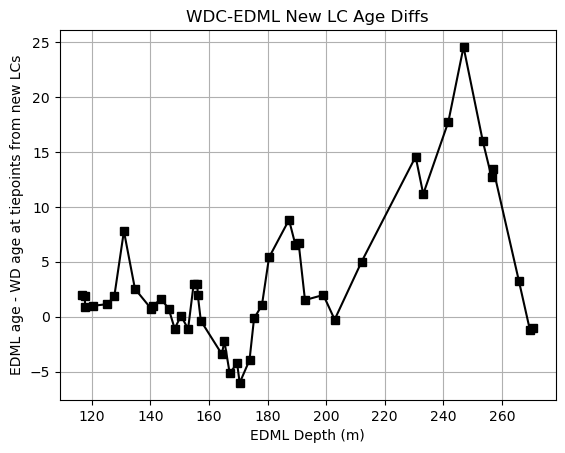

In [132]:
wdc_edml_tiepoints['closest_edml_lc_age'] = np.round(np.interp(wdc_edml_tiepoints['EDML m'], EDML_reset_depth['Depth (m)'], EDML_reset_depth['age (b1950)']))

wdc_edml_tiepoints['age_diff'] = wdc_edml_tiepoints['closest_edml_lc_age'] - wdc_edml_tiepoints['new_wdc age']


plot_diff = wdc_edml_tiepoints[wdc_edml_tiepoints['EDML m'] < 272.3].copy(deep=True)

plt.plot(plot_diff['EDML m'], plot_diff['age_diff'], marker='s', linestyle='-', color='k')
plt.ylabel('EDML age - WD age at tiepoints from new LCs')
plt.xlabel('EDML Depth (m)')
plt.grid()
plt.title('WDC-EDML New LC Age Diffs')